In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, log_loss, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Загрузка датасета

df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
# Разбивка датасета на train и test 

X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=15)

In [4]:
# Сборка пайплайна

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [5]:
# Объединение трансформеров

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.75553215, -0.04182147,  2.83329924, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.37465632, -0.53000989,  2.76379201, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.40548333,  0.93455536,  0.95660386, ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [-0.22565916, -1.14024541, -1.40664217, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.34423493,  0.08022563, -0.98959875, ...,  0.        ,
         0.        ,  1.        ],
       [-0.18104112,  0.08022563,  0.60211696, ...,  1.        ,
         0.        ,  1.        ]])

In [6]:
# Классификатор

classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state=15))])

In [7]:
# Кросс-валидация

cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7880979948390523+-0.00859550868732631


In [8]:
# Обучение пайплайна

classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

In [9]:
# Функция расчета метрик

def cal_metrics(y_test, y_score):
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_test, y_score)
    log_loss_ = log_loss(y_test, y_score) 
    
    metrics = (roc_auc, log_loss_, fscore[ix], precision[ix], recall[ix])
    
    return metrics

In [12]:
# Расчет метрик

metrics_logreg = cal_metrics(y_test, y_score)

metrics_logreg

(0.7799293101460039,
 0.5852283132261172,
 0.7275218185508424,
 0.6534500045574697,
 0.8205333638548701)

In [13]:
# Функция построения ROC-AUC кривой 

def roc_auc_curve(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(6, 6))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

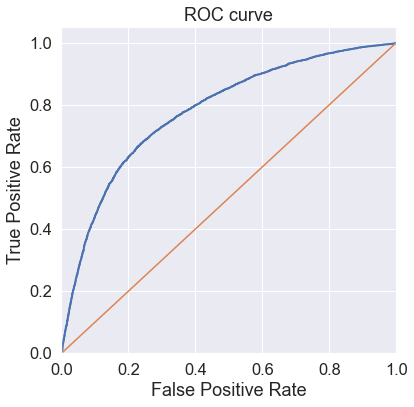

In [14]:
# Построение ROC-AUC кривой

roc_auc_curve(y_test, y_score)

# RandomForestClassifier

In [18]:
# Классификатор

classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=10, min_samples_leaf=5,\
                                          min_samples_split=15, n_estimators=100, random_state=15))])

In [19]:
# Кросс-валидация

cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.8031544755717299+-0.007065692093871473


In [20]:
# Обучение пайплайна

classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

In [21]:
# Расчет метрик

metrics_forest = cal_metrics(y_test, y_score)

metrics_forest

(0.7965874824265735,
 0.5462589369388505,
 0.736548013245033,
 0.6720800679822491,
 0.8146961199496394)

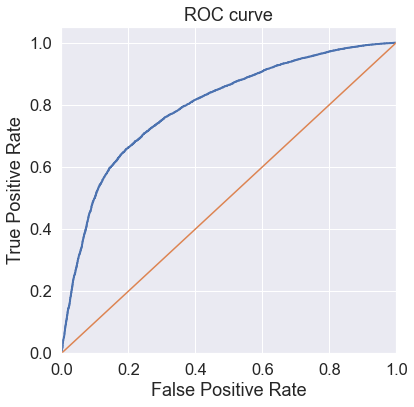

In [22]:
# Построение ROC-AUC кривой

roc_auc_curve(y_test, y_score)

# LightGBM

In [39]:
# Классификатор

classifier = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(random_state=15))])

In [40]:
# Кросс-валидация

cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.8039711951210031+-0.006101689293969509


In [41]:
# Обучение пайплайна

classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

In [42]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
ix = np.argmax(fscore)

thresholds[ix]

<ipython-input-42-ac7b2b65020b>:3: RuntimeWarning: invalid value encountered in true_divide
  fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)


0.9624097655215237

In [43]:
# Расчет метрик

metrics_lgbm = cal_metrics(y_test, y_score)

metrics_lgbm

<ipython-input-9-d05987504f76>:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)


(0.7981166286590726, 0.544298691392843, nan, 0.0, 0.0)

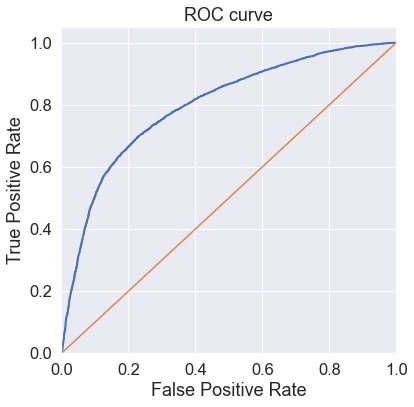

In [44]:

# Построение ROC-AUC кривой

roc_auc_curve(y_test, y_score)

In [45]:
all_metrics = (metrics_logreg, metrics_forest, metrics_lgbm)

table = pd.DataFrame(list(all_metrics), columns=['roc-auc', 'log_loss','f-score', 'precision', 'recall'], \
                     index=['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier'])

In [46]:
table

,roc-auc,log_loss,f-score,precision,recall
LogisticRegression,0.779929,0.585228,0.727522,0.65345,0.820533
RandomForestClassifier,0.796587,0.546259,0.736548,0.67208,0.814696
LGBMClassifier,0.798117,0.544299,NaN,0.00000,0.000000


Особых различий нет